### Configuration

In [1]:
import sqlite3
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import *
import sys
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import psutil
import random
import numpy as np
import seaborn as sns
from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
spark = SparkSession.builder \
    .appName("suggestify") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "1") \
    .getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 200)
spark.conf.set("spark.default.parallelism", 200)

your 131072x1 screen size is bogus. expect trouble
25/03/28 12:47:13 WARN Utils: Your hostname, SSMRS3-04919600 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/03/28 12:47:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/28 12:47:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
venv_path = os.path.dirname(os.path.dirname(sys.executable))

#conseguir direccion del proyecto, donde esta la bd
project_path = os.path.dirname(venv_path)

### Dataframe retrieval

In [4]:
sqlite_conn = sqlite3.connect(project_path+"/extracted.db") #clase
#sqlite_conn = sqlite3.connect(venv_path+"/extracted.db") #portatil
#sqlite_conn = sqlite3.connect("/home/enekobarba/bigdata/extracted.db")

cursor = sqlite_conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in SQLite:", tables)

df = pd.read_sql("SELECT * FROM extracted", sqlite_conn)

sqlite_conn.close()

df.head()

Tables in SQLite: [('extracted',)]


,track_uri,track_name,artist_name,artist_uri,album_name,album_uri,duration_ms,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,fduration_ms,time_signature
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,0.904,0.813,4,...,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,0.774,0.838,5,...,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,0.664,0.759,2,...,0.0598,0.701,99.252,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,0.892,0.714,4,...,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,0.853,0.606,0,...,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4


In [5]:
df.shape

(2261644, 25)

We'll now separate the columns from which we can get insights into what relationships and patterns our data hides. This next dataframe, "df_sample_others", is the collection of columns containing uris and references, that we will maybe later on use, but for now, we'll put them aside and focus our attention into "df_sample".

Defining the track_uri as a id for each song could be a simple option, however, as it contains letters, it will later on crash. Taking that into account, we'll define a unique identifier based on the track_uri as follows:

In [6]:
df['track_id'] = df['track_uri'].astype('category').cat.codes
df['artist_id'] = df['artist_name'].astype('category').cat.codes
df['album_id'] = df['album_name'].astype('category').cat.codes


In [7]:
df_sample = df[["track_id", "track_name", "artist_name", "artist_id", "album_name", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]

df_sample_others = df[["track_id", "track_uri", "artist_uri", "album_uri", "type", "uri", "id", "fduration_ms", "track_href", "analysis_url"]]

We can now clean the data, and separate the numerical data from the categorical, using the id in both as identification

In [8]:
df_sample_numerical = df_sample[["track_id", "artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]

df_sample_categorical = df_sample[["track_id", "track_name", "artist_name", "album_name"]]

In [9]:
df_sample.set_index("track_id", inplace=True)
df_sample_others.set_index("track_id", inplace=True)
df_sample_numerical.set_index("track_id", inplace=True)
df_sample_categorical.set_index("track_id", inplace=True)

### Intento de KMeans con Pandas

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [11]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sample_numerical)

In [12]:
#apply PCA (sin std)
pca = PCA(n_components=4) 
df_pca = pca.fit_transform(df_scaled)

### PC1, PC2

In [13]:
#KMeans with k=10
kmeans = KMeans(n_clusters=10, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(df_pca)

/tmp/ipykernel_8207/2543915891.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['cluster'] = kmeans.fit_predict(df_pca)


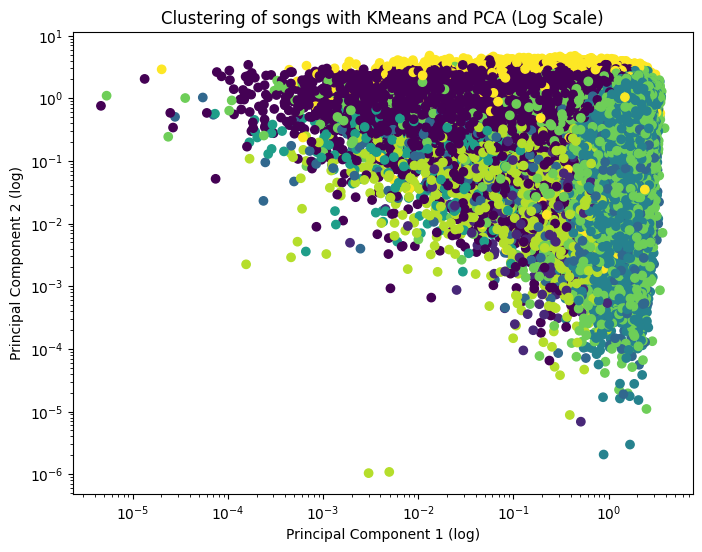

In [14]:
#visualization
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_sample['cluster'], cmap='viridis')
plt.xscale('log')
plt.yscale('log')
plt.title('Clustering of songs with KMeans and PCA (Log Scale)')
plt.xlabel('Principal Component 1 (log)')
plt.ylabel('Principal Component 2 (log)')
plt.show()

-----------------------------------------------
Percentage of explained variance per component:
-----------------------------------------------
[0.21213641 0.09000128 0.08149928 0.0790624 ]


Text(0, 0.5, 'Explained variance')

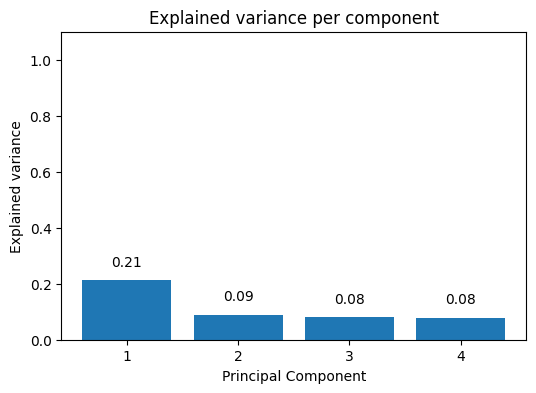

In [15]:
print('-----------------------------------------------')
print('Percentage of explained variance per component:')
print('-----------------------------------------------')
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df_sample.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Explained variance per component')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained variance')

In [16]:
print('-------------------------------------------------------------------------')
print('Explainability per variable for each the first four principal components:')
print('-------------------------------------------------------------------------')
print(pca.components_)

-------------------------------------------------------------------------
Explainability per variable for each the first four principal components:
-------------------------------------------------------------------------
[[ 0.00901523  0.00381833 -0.05510024  0.30926595  0.48267539  0.04157388
   0.47671251 -0.04613078  0.11887926 -0.42754624 -0.26741997  0.08770411
   0.32384816  0.16428789  0.17068754]
 [-0.05074011 -0.04794546 -0.41356834  0.45694892 -0.27056207 -0.03998625
  -0.14168381  0.13600707  0.16671057  0.30180714 -0.25371241 -0.22352689
   0.44859318 -0.25967007  0.00565801]
 [ 0.00624642  0.00223088 -0.1420878  -0.2472774   0.02945022 -0.24222589
   0.02060202  0.32278696  0.42836583  0.10206146 -0.31556001  0.62054381
  -0.08421189 -0.02940853 -0.26065556]
 [ 0.11963452  0.04933884 -0.12029505 -0.09826226  0.02727599 -0.52277298
   0.11301086  0.58409683 -0.45532361 -0.05279341 -0.02901751 -0.25425632
   0.03301793  0.23327026  0.00710927]]


In [17]:
print('--------------------------------------------------------------')
print('Explainability per variable for the first PC:')
print('--------------------------------------------------------------')
# Obtener los loadings del primer componente
pc1_loadings = pca.components_[0]

# Nombres de las variables originales
variables = ["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]



# Crear un DataFrame con los resultados
df_loadings = pd.DataFrame({
    'Variable': variables,
    'Explainability per variable PC1': pc1_loadings
})

df_loadings

--------------------------------------------------------------
Explainability per variable for the first PC:
--------------------------------------------------------------


,Variable,Explainability per variable PC1
0,artist_id,0.009015
1,album_id,0.003818
2,duration_ms,-0.055100
3,danceability,0.309266
4,energy,0.482675
5,key,0.041574
6,loudness,0.476713
7,mode,-0.046131
8,speechiness,0.118879
9,acousticness,-0.427546


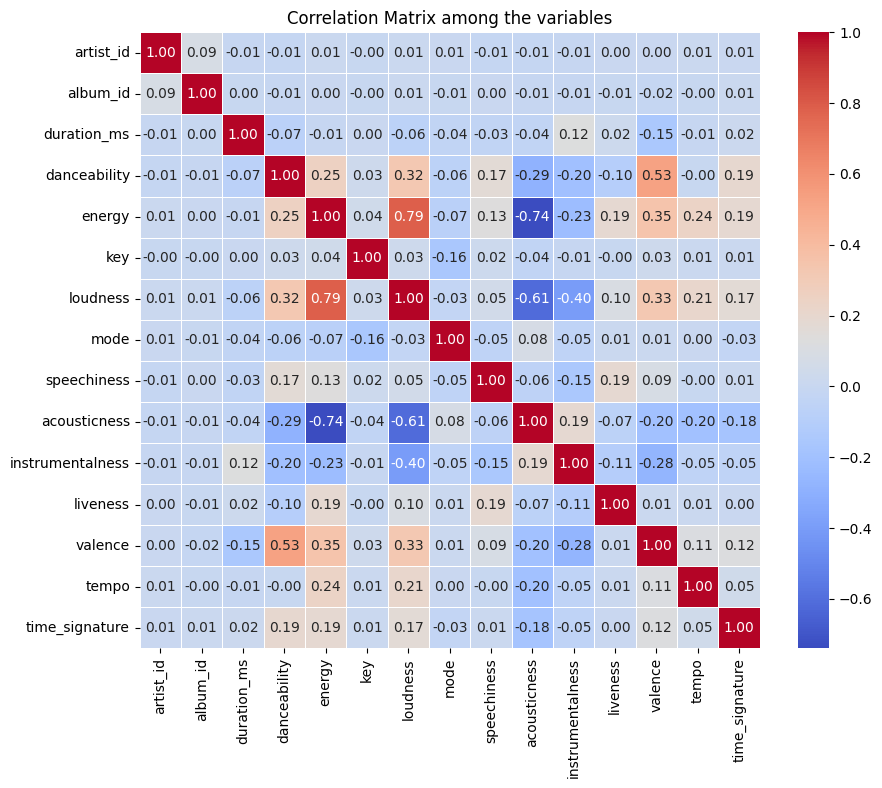

In [18]:
# Calcular la matriz de correlación
corr_matrix = df_sample_numerical[["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]].corr()

# Crear un gráfico de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix among the variables")
plt.show()

In [19]:
from sklearn.metrics import silhouette_score
best_key=0
best_score=-1
X = df_pca[:5000]
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    if score> best_score:
        best_key=k
        best_score=score
    print(f"k={k}, silhouette score={score:.3f}")
print(f"Best k={best_key}, silhouette score={best_score:.3f}")

k=best_key


k=2, silhouette score=0.212
k=3, silhouette score=0.236
k=4, silhouette score=0.215
k=5, silhouette score=0.221
k=6, silhouette score=0.209
k=7, silhouette score=0.203
k=8, silhouette score=0.182
k=9, silhouette score=0.189
k=10, silhouette score=0.192
k=11, silhouette score=0.185
k=12, silhouette score=0.185
k=13, silhouette score=0.183
k=14, silhouette score=0.186
Best k=3, silhouette score=0.236


### TSNE viejo

#### con 100

In [20]:
numerical_features = ["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]


scaler = StandardScaler()
df_scaled1 = scaler.fit_transform(df_sample_numerical[numerical_features].iloc[:100])

In [21]:
tsne = TSNE(n_components=3, perplexity=50, random_state=42)
df_tsne = tsne.fit_transform(df_scaled1)

In [22]:
df_sample_100 = df_sample.iloc[:100].copy()

kmeans = KMeans(n_clusters=k, random_state=42)
df_sample_100['cluster'] = kmeans.fit_predict(df_tsne)

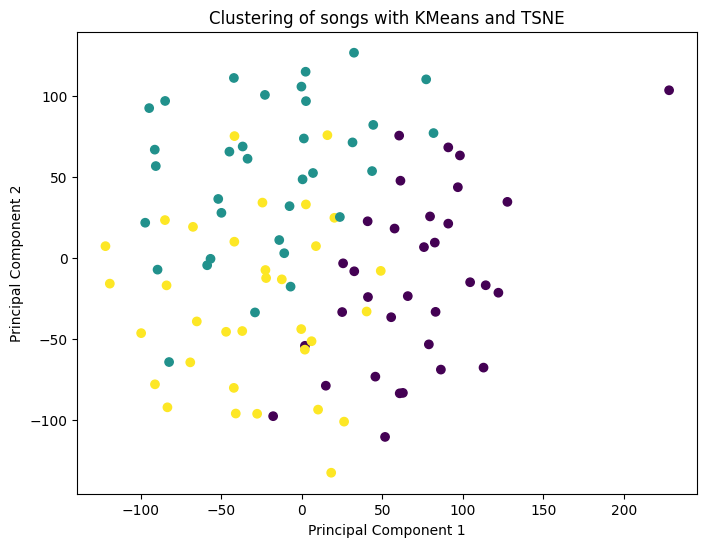

In [23]:
#visualization
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=df_sample_100['cluster'], cmap='viridis')
plt.title('Clustering of songs with KMeans and TSNE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### con 1000

In [24]:
numerical_features = ["danceability", "energy", "key", "loudness", 
                      "mode", "speechiness", "acousticness", "instrumentalness", 
                      "liveness", "valence", "tempo", "time_signature"]

scaler = StandardScaler()
df_scaled2 = scaler.fit_transform(df_sample_numerical[numerical_features].iloc[:1000])

In [25]:
tsne = TSNE(n_components=3, perplexity=50, random_state=42)
df_tsne = tsne.fit_transform(df_scaled2)

In [26]:
df_sample_1000 = df_sample.iloc[:1000].copy()

kmeans = KMeans(n_clusters=k, random_state=42)
df_sample_1000['cluster'] = kmeans.fit_predict(df_tsne)

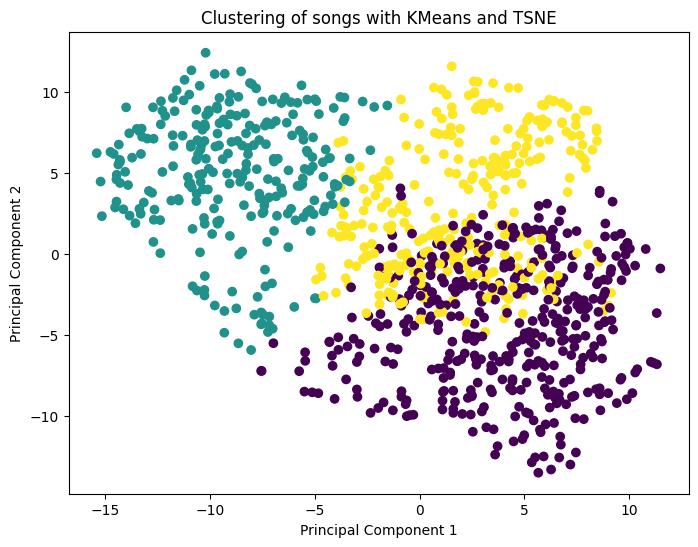

In [27]:
#visualization
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=df_sample_1000['cluster'], cmap='viridis')
plt.title('Clustering of songs with KMeans and TSNE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Celdas de Voronoi

/home/noraibarguren/myproject/bigdataenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


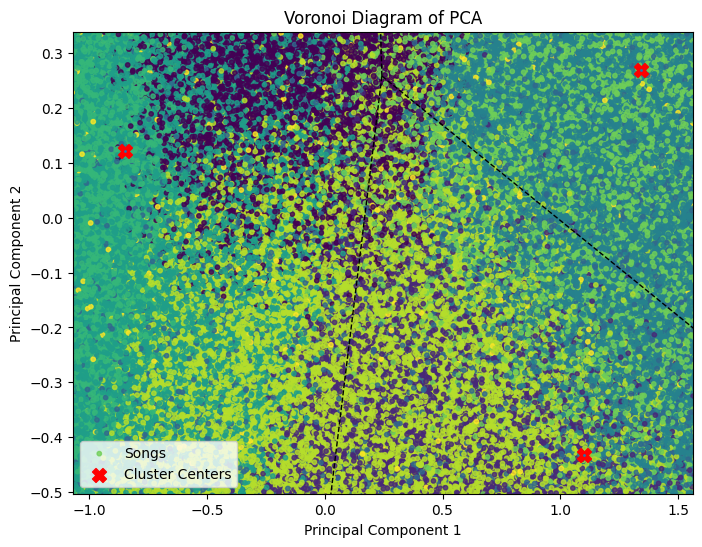

In [28]:
df_sample_voronoi = df_sample.iloc[:1000].copy()
df_sample_voronoi['cluster'] = kmeans.fit_predict(df_pca[:1000])  # <-- usa PCA aquí

# Los centros ya están en espacio PCA
centers_2d = kmeans.cluster_centers_[:, :2]

df_pca_2d = df_pca[:, :2]

centers_2d = kmeans.cluster_centers_[:, :2]

vor = Voronoi(centers_2d)

fig, ax = plt.subplots(figsize=(8, 6))

voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors="black", line_width=1, point_size=2)

scatter = ax.scatter(df_pca_2d[:, 0], df_pca_2d[:, 1],
                     c=df_sample['cluster'], cmap='viridis', s=10, alpha=0.8,
                     label='Songs')

ax.scatter(centers_2d[:, 0], centers_2d[:, 1],
           marker='X', s=100, color='red', label='Cluster Centers')

#plt.xscale("log")
#plt.yscale("log")

plt.title('Voronoi Diagram of PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

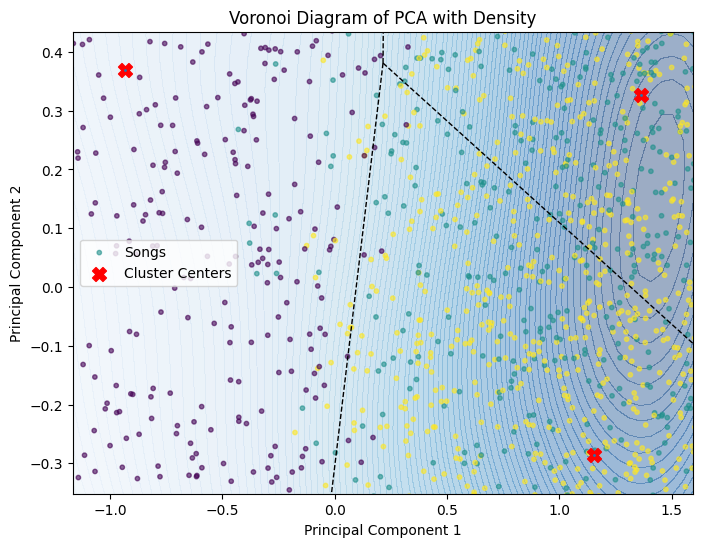

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import Voronoi, voronoi_plot_2d

# Usamos solo los 1000 puntos ya muestreados
df_sample_voronoi = df_sample.iloc[:5000].copy()
df_sample_voronoi['cluster'] = kmeans.fit_predict(df_pca[:5000])

# PCA reducido a 2D
df_pca_2d = df_pca[:5000, :2]
centers_2d = kmeans.cluster_centers_[:, :2]

# Voronoi diagram
vor = Voronoi(centers_2d)

fig, ax = plt.subplots(figsize=(8, 6))

# Voronoi plot
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors="black", line_width=1, point_size=2)

# Densidad (seaborn kdeplot)
sns.kdeplot(
    x=df_pca_2d[:, 0], 
    y=df_pca_2d[:, 1], 
    ax=ax, 
    cmap="Blues", 
    fill=True, 
    thresh=0.05, 
    levels=100, 
    alpha=0.4
)

# Canciones
scatter = ax.scatter(
    df_pca_2d[:, 0], df_pca_2d[:, 1],
    c=df_sample_voronoi['cluster'], cmap='viridis', s=10, alpha=0.6,
    label='Songs'
)

# Centros de clústeres
ax.scatter(
    centers_2d[:, 0], centers_2d[:, 1],
    marker='X', s=100, color='red', label='Cluster Centers'
)

plt.title('Voronoi Diagram of PCA with Density')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Recommendations to user content-based

In [ ]:
UID=1

se supone que se le recomiendan unas canciones y les da like o no o super

dislike: -1
like: 1
saltar: 0
super like :2

In [ ]:
ratings=pd.DataFrame( columns=["user", "track_id", "rating"])

In [ ]:
rating_map = {
    "dislike": -1,
    "like": 1,
    "saltar": 0,
    "super like": 2
}


while ratings.shape[0] < 20:
    num_aleatorio = random.randint(0, len(df_sample) - 1)
    
    #info de canción
    try:
        cancion = df_sample.loc[num_aleatorio]
        nombre_cancion = cancion['track_name']
        artista = cancion['artist_name']
    except (KeyError, IndexError):
        nombre_cancion = "Canción desconocida"
        artista = "Artista desconocido"

    
    while True:
        input_usuario = input(f"\n🎵 Canción: {nombre_cancion} - {artista}\n""Ingrese su calificación (dislike/like/saltar/super like): ").strip().lower()        
        if input_usuario in rating_map:
            rating = rating_map[input_usuario]
            break
        else:
            print("⚠️ Entrada inválida. Ingrese una opción válida: dislike, like, saltar, super like.")

    nueva_fila = [UID, num_aleatorio, rating]
    ratings.loc[ratings.shape[0]] = nueva_fila


dislike: -1
like: 1
saltar: 0
super like :2

In [ ]:
ratings

In [ ]:
!pip install umap-learn
!pip install numpy==2.1.0 --force-reinstall --upgrade

In [ ]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import umap.umap_ as umap
import os

In [ ]:
# Before generating recommendations, ensure df_scaled uses the full dataset
numerical_features = ["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

# Use the full dataset for scaling and PCA
scaler = StandardScaler()
df_scaled_full = scaler.fit_transform(df_sample_numerical[numerical_features])  # Full dataset

pca = PCA(n_components=4)
reduced_features_full = pca.fit_transform(df_scaled_full).astype(np.float32)

### He intentado lo de estas celdas pero peta

In [ ]:
def reduce_features(df, numerical_features, n_components=5):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[numerical_features])
    try:
        reducer = umap.UMAP(
            n_components=n_components,
            metric='cosine',
            n_neighbors=10,
            low_memory=True,
            random_state=42
        )
        reduced = reducer.fit_transform(df_scaled).astype(np.float32)
    except Exception as e:
        reducer = PCA(n_components=n_components)
        reduced = reducer.fit_transform(df_scaled).astype(np.float32)

    return df_scaled, reduced

In [ ]:
numerical_features = [
    "artist_id", "album_id", "duration_ms", "danceability", "energy", "key",
    "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo", "time_signature"
]

df_scaled_full, reduced_features_full = reduce_features(df_sample_numerical, numerical_features)

### Esto ya va bien

In [ ]:
# Rebuild the NearestNeighbors model with the full dataset
nn_model_full = NearestNeighbors(
    n_neighbors=50,
    metric='cosine',
    algorithm='auto',
    n_jobs=-1
).fit(reduced_features_full)


In [ ]:
def content_based_recommendation(user_ratings, df_original, df_scaled, reduced_features, 
                               top_n=10, diversity=0.7, batch_size=100):
    """
    Sistema de recomendación basado en contenido mejorado con:
    - Manejo de dataset completo
    - Mapeo correcto de índices
    - Diversidad de recomendaciones
    """
    # 1. Preparar datos y modelos
    nn_model = NearestNeighbors(n_neighbors=50, metric='cosine', algorithm='auto', n_jobs=-1).fit(reduced_features)
    df_original_reset = df_original.reset_index()
    track_id_to_idx = {track_id: idx for idx, track_id in enumerate(df_original_reset['track_id'])}
    
    # 2. Filtrar y mapear calificaciones válidas
    valid_ratings = user_ratings[user_ratings['track_id'].isin(df_original_reset['track_id'])].copy()
    if valid_ratings.empty:
        return df_original_reset.sample(min(top_n, len(df_original_reset)))
    
    valid_ratings['track_idx'] = valid_ratings['track_id'].map(track_id_to_idx)
    valid_ratings = valid_ratings.dropna(subset=['track_idx'])
    
    # 3. Configurar pesos y exclusiones
    #rating_weights = valid_ratings['rating'].map({-2: -2.0, -1: -1.0, 0: 0.0, 1: 1.0, 2: 2.0})
    weight_map = {-1: -1.0, 0: 0.0, 1: 1.0, 2: 2.0}
    rating_weights = valid_ratings['rating'].map(weight_map)
    track_indices = valid_ratings['track_idx'].astype(int).values
    weights = rating_weights.values
    
    # 4. Búsqueda por lotes de vecinos similares
    all_scores = np.zeros(reduced_features.shape[0])
    rated_tracks = set()
    
    for i in range(0, len(track_indices), batch_size):
        batch_indices = track_indices[i:i + batch_size]
        batch_weights = weights[i:i + batch_size]
        
        distances, indices = nn_model.kneighbors(reduced_features[batch_indices])
        similarities = 1 / (1 + distances)
        weighted_scores = similarities * batch_weights[:, np.newaxis]
        
        # Actualizar puntuaciones acumuladas
        np.add.at(all_scores, indices.ravel(), weighted_scores.ravel())
        rated_tracks.update(batch_indices.tolist())
    
    # 5. Aplicar diversidad y exclusión
    noise = (np.random.rand(len(all_scores)) - 0.5) * 2 * diversity * np.mean(np.abs(all_scores))
    final_scores = all_scores * (1 - diversity) + noise
    
    # Excluir tracks ya calificados
    final_scores[list(rated_tracks)] = -np.inf
    
    # 6. Obtener mejores recomendaciones
    top_indices = np.argsort(final_scores)[-top_n:][::-1]
    valid_indices = top_indices[final_scores[top_indices] > -np.inf]
    
    if len(valid_indices) == 0:
        return pd.DataFrame(columns=df_original.columns)
    
    return df_original_reset.iloc[valid_indices].set_index('track_id')


In [ ]:
#recomendar
recommendations = content_based_recommendation(
    user_ratings=ratings,
    df_original=df_sample,
    df_scaled=df_scaled_full,
    reduced_features=reduced_features_full,
    top_n=5,
    diversity=0.3
)

print("Recommendations:")
print(recommendations[['track_name', 'artist_name']])

# Otros

## PC3, PC4

In [ ]:
df_pca_34 = pd.DataFrame(df_pca[:, 2:], columns=['PC3', 'PC4'])

In [ ]:
#KMeans with k=10
kmeans = KMeans(n_clusters=10, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(df_pca_34)

In [ ]:
# Visualización corregida
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_34['PC3'], df_pca_34['PC4'], c=df_sample['cluster'], cmap='viridis')
plt.title('Clustering of songs with KMeans and PCA')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.colorbar(label='cluster')
plt.show()

## Spark

### Spark Dataframe

In [ ]:
#columns for clustering
feature_columns = ["danceability", "energy", "key", "loudness", "mode",
                   "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_raw")
assembled_df = assembler.transform(spark_df).repartition(500).cache()
assembled_df.count()

### Intento de KMeans con Spark

In [ ]:
schema = StructType([
    StructField("track_uri", StringType(), True),
    StructField("track_name", StringType(), True),
    StructField("artist_name", StringType(), True),
    StructField("album_name", StringType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("danceability", FloatType(), True),
    StructField("energy", FloatType(), True),
    StructField("key", IntegerType(), True),
    StructField("loudness", FloatType(), True),
    StructField("mode", IntegerType(), True),
    StructField("speechiness", FloatType(), True),
    StructField("acousticness", FloatType(), True),
    StructField("instrumentalness", FloatType(), True),
    StructField("liveness", FloatType(), True),
    StructField("valence", FloatType(), True),
    StructField("tempo", FloatType(), True),
    StructField("time_signature", IntegerType(), True)
])

spark_df = spark.createDataFrame(df_sample, schema=schema)

spark_df.show(5)

In [ ]:
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df).select("features").cache()
scaled_df.count()

In [ ]:
#KMeans with 10 clusters
kmeans = KMeans(k=10, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(scaled_df)

In [ ]:
#predictions
clustered_df = model.transform(assembled_df)

In [ ]:
#plotting the clusters
pandas_df = clusters_df.select("danceability", "energy", "cluster").toPandas() #transform to pandas for plotting
plt.figure(figsize=(10, 6))
for cluster in range(10):
    cluster_data = pandas_df[pandas_df['cluster'] == cluster]
    plt.scatter(cluster_data['danceability'], cluster_data['energy'], label=f'Cluster {cluster}')

plt.title('Clustering de canciones por danceability y energy')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.legend()
plt.show()